# Gaussian Stochastic Volatility Model 

In [9]:
using Gen
using Random

In [10]:

@gen function sv_model(T::Int)
    # priors - explained in report
    # Mean of log-volatility
    μ = {:mu} ~ normal(0.0, 1.0)
    
    # Persistence parameter
    φ = {:phi} ~ uniform(-0.99, 0.99)
    
    # Volatility of log-volatility 
    σ = {:sigma} ~ Gen.gamma(2.0, 0.5)  # shape=2, scale=0.5, mean=1.0
    
    # Latent log-volatility process (AR(1)) (simplest one I found online)
    h = Vector{Float64}(undef, T)
    
    # First state: draw from stationary distribution
    # Stationary variance of AR(1): σ² / (1 - φ²)
    h1_std = σ / sqrt(1 - φ^2)
    h[1] = {(:h, 1)} ~ normal(μ, h1_std)
    
    # Subsequent states: AR(1) transitions
    for t in 2:T
        h_mean = μ + φ * (h[t-1] - μ)
        h[t] = {(:h, t)} ~ normal(h_mean, σ)
    end
    
    # Obsercvations
    y = Vector{Float64}(undef, T)
    for t in 1:T
        y_std = exp(h[t] / 2)  # standard deviation of observation
        y[t] = {(:y, t)} ~ normal(0.0, y_std)
    end
    
    return (h=h, y=y)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64], false, Union{Nothing, Some{Any}}[nothing], Main.var"##sv_model#284", Bool[0], false)

In [11]:

function simulate_data(T::Int; seed::Int=42)
    Random.seed!(seed)
    
    trace = Gen.simulate(sv_model, (T,))
    
    # ture params from trace
    μ_true = trace[:mu]
    φ_true = trace[:phi]
    σ_true = trace[:sigma]
    
    # latent states and observations from trace
    h = [trace[(:h, t)] for t in 1:T]
    y = [trace[(:y, t)] for t in 1:T]
    
    true_params = (μ=μ_true, φ=φ_true, σ=σ_true)
    
    return trace, y, true_params, h
end

simulate_data (generic function with 1 method)

In [12]:
# Simulate synthetic data
T = 200  # time series length
seed = 123

println("Simulating stochastic volatility data (T=$T)")
println("=" ^ 50)

trace, y, true_params, h_true = simulate_data(T; seed=seed)

println("\nTrue parameters:")
println("  μ (mean log-vol)     = $(true_params.μ)")
println("  φ (persistence)      = $(true_params.φ)")
println("  σ (vol of log-vol)   = $(true_params.σ)")

# Compute volatility from log-volatility
vol_true = exp.(h_true ./ 2)


println("\nData summary:")
println("  y (returns) range: [$(minimum(y)), $(maximum(y))]")
println("  Volatility range:  [$(minimum(vol_true)), $(maximum(vol_true))]")


Simulating stochastic volatility data (T=200)

True parameters:
  μ (mean log-vol)     = -0.6457306721039767
  φ (persistence)      = 0.17187737975762984
  σ (vol of log-vol)   = 0.16325636488107312

Data summary:
  y (returns) range: [-1.93456941798914, 2.583812197223785]
  Volatility range:  [0.5733445263986103, 0.9359347932291374]


## Visualize the Simulated Data

Plot the returns, latent log-volatility, and volatility time series.

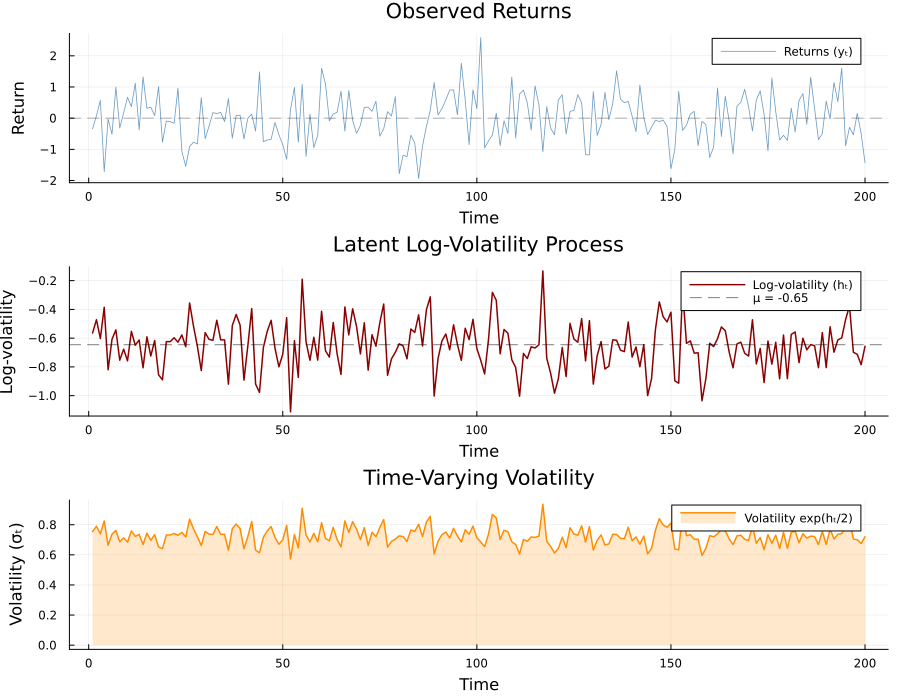

In [13]:
using Plots

ts = 1:T

# Plot 1: Returns (observed data)
p1 = plot(ts, y,
    label="Returns (yₜ)",
    linewidth=0.8,
    color=:steelblue,
    xlabel="Time",
    ylabel="Return",
    title="Observed Returns",
    alpha=0.8)
hline!(p1, [0], color=:black, linestyle=:dash, label="", alpha=0.3)

# Plot 2: Latent log-volatility process
p2 = plot(ts, h_true,
    label="Log-volatility (hₜ)",
    linewidth=1.5,
    color=:darkred,
    xlabel="Time",
    ylabel="Log-volatility",
    title="Latent Log-Volatility Process")
hline!(p2, [true_params.μ], color=:black, linestyle=:dash, 
    label="μ = $(round(true_params.μ, digits=2))", alpha=0.5)

# Plot 3: Volatility (standard deviation of returns)
p3 = plot(ts, vol_true,
    label="Volatility exp(hₜ/2)",
    linewidth=1.5,
    color=:darkorange,
    xlabel="Time",
    ylabel="Volatility (σₜ)",
    title="Time-Varying Volatility",
    fill=0, fillalpha=0.2)

# Combined layout
plot(p1, p2, p3, layout=(3, 1), size=(900, 700), legend=:topright)